<a href="https://colab.research.google.com/github/elluy-gabriel-p/Capstone_ML/blob/norma/test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install pillow

In [2]:
# Hapus folder Capstone_ML
!rm -rf Capstone_ML

# Clone repository dari branch norma
!git clone --branch norma https://github.com/elluy-gabriel-p/Capstone_ML.git

# Cek isi folder dataset
!ls Capstone_ML/data/dataset_padang_food

# Path dataset untuk digunakan dalam model
DATASET_PATH = '/content/Capstone_ML/data/dataset_padang_food'

Cloning into 'Capstone_ML'...
remote: Enumerating objects: 1054, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 1054 (delta 24), reused 46 (delta 20), pack-reused 999 (from 1)
Receiving objects: 100% (1054/1054), 171.80 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (1000/1000), done.
ayam_goreng  daging_rendang   gulai_ikan     gulai_tunjang  telur_dadar
ayam_pop     dendeng_batokok  gulai_tambusu  telur_balado


**Data preparation and Processing**

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Parameter untuk data
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/Capstone_ML/data/dataset_padang_food'

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Memuat data train dan validasi
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

validation_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)


Found 799 images belonging to 9 classes.
Found 194 images belonging to 9 classes.


**Buid Model with Transfer Learning**

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Menggunakan MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze layer

# Menambahkan lapisan khusus untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train Model**

In [6]:
# Callback untuk Early Stopping dan Model Checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# Melatih model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.3525 - loss: 1.8151 - val_accuracy: 0.7835 - val_loss: 0.6557
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7950 - loss: 0.6145 - val_accuracy: 0.8144 - val_loss: 0.5187
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8973 - loss: 0.3522 - val_accuracy: 0.8299 - val_loss: 0.5395
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9011 - loss: 0.3196 - val_accuracy: 0.8351 - val_loss: 0.4915
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9236 - loss: 0.2461 - val_accuracy: 0.8505 - val_loss: 0.4974
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9383 - loss: 0.1893 - val_accuracy: 0.8247 - val_loss: 0.4910
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9366 - loss: 0.1803 - val_accuracy: 0.8557 - val_loss: 0.4564
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9294 - loss: 0.2263 - val_accuracy: 0.8557 - val_loss: 0.4569
Epo

**Evaluasi Model Keseluruhan**

In [7]:
# Evaluasi model menggunakan dataset validasi
loss, accuracy = model.evaluate(validation_data)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8795 - loss: 0.4137
Validation Accuracy: 87.11%
Validation Loss: 0.4277


**Tes Prediksi Gambar**

In [11]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Ambil ukuran gambar dari parameter IMAGE_SIZE
IMG_HEIGHT, IMG_WIDTH = IMAGE_SIZE  # IMAGE_SIZE sudah didefinisikan sebelumnya

# Fungsi untuk memproses dan memprediksi gambar
def predict_uploaded_image(uploaded_file, model, class_indices):
    # Muat gambar dari file
    img = image.load_img(uploaded_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Prediksi dengan model
    predictions = model.predict(img_array)
    class_names = list(class_indices.keys())  # Dapatkan nama kelas dari indeks
    predicted_class = class_names[np.argmax(predictions)]  # Kelas dengan confidence tertinggi

    return predicted_class, predictions

# Upload gambar dari pengguna
uploaded = files.upload()  # Widget untuk mengunggah gambar

if uploaded:
    for file_name in uploaded.keys():
        print(f"\nProcessing file: {file_name}")

        # Gunakan indeks kelas dari data pelatihan
        class_indices = train_data.class_indices

        # Prediksi gambar yang diunggah
        predicted_food, predictions = predict_uploaded_image(file_name, model, class_indices)

        # Menampilkan hasil
        print(f"Predicted class: {predicted_food}")
        print(f"Prediction probabilities: {predictions}")


Saving datatrain.jpg to datatrain.jpg

Processing file: datatrain.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted class: ayam_pop
Prediction probabilities: [[6.4187923e-05 9.9982709e-01 5.0082200e-08 6.1684163e-10 1.0290358e-04
  6.1910976e-07 5.1725383e-06 7.6234494e-09 5.0486456e-08]]


**Cek Performa model**

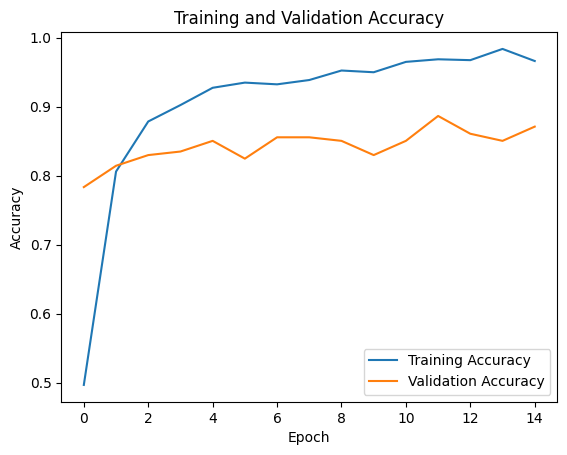

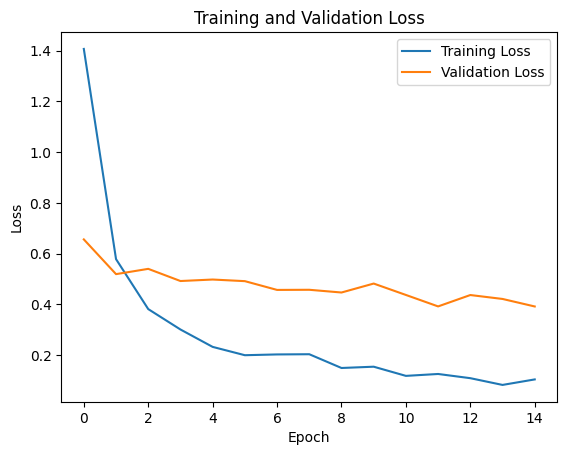

In [12]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Ambil nilai epoch terakhir
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Hitung perbedaan
loss_difference = abs(final_train_loss - final_val_loss)
accuracy_difference = abs(final_train_accuracy - final_val_accuracy)

# Tampilkan hasil
print("Final Epoch Results:")
print("-" * 30)
print(f"Training Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}, Difference: {loss_difference:.4f}")
print(f"Training Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}, Difference: {accuracy_difference:.4f}")


Final Epoch Results:
------------------------------
Training Loss: 0.1033, Validation Loss: 0.3911, Difference: 0.2878
Training Accuracy: 0.9662, Validation Accuracy: 0.8711, Difference: 0.0951
